In [457]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit

In [458]:
training_history_df = pd.read_csv('training_history.csv')
training_history_df_sorted = training_history_df.sort_values(by='Measured Stimulus')
training_history_df_sorted

,Trial,Truth,Measured Stimulus,Decision,HP
128,129,False,-3.077543,False,1145
798,799,False,-2.552603,True,1956
1379,1380,False,-2.540033,False,2613
448,449,False,-2.475221,False,1532
611,612,False,-2.460250,False,1715
...,...,...,...,...,...
988,989,True,4.324708,True,2152
191,192,True,4.451974,True,1195
52,53,True,4.620112,True,1070
381,382,True,4.692448,True,1427


mu: 0.9260454796456572
sigma: 1.1840094933952496


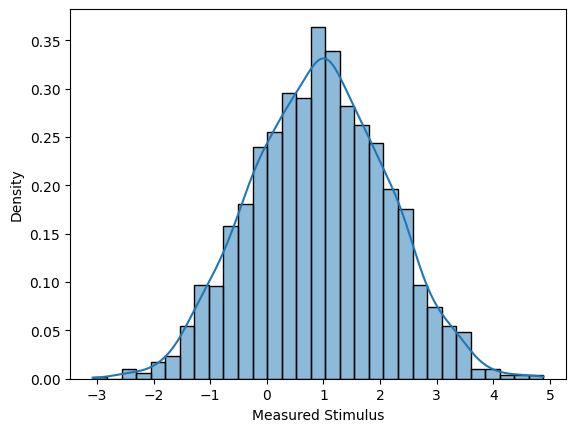

In [459]:
mu = training_history_df['Measured Stimulus'].mean()
sigma = training_history_df['Measured Stimulus'].std()

print(f"mu: {mu}")
print(f"sigma: {sigma}")

sns.histplot(training_history_df['Measured Stimulus'], kde=True, stat='density')

plt.xlabel('Measured Stimulus')
plt.ylabel('Density')
plt.show()

In [460]:
def generate_data_csv(min_stimulus, max_stimulus, step, n_trial, s_ref, s_ref_std, experiment_name):
    data = []  
    stimulus_std_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for stimulus_std in stimulus_std_values: 
        stimulus_values = np.arange(min_stimulus, max_stimulus + step, step)  
        for stimulus in stimulus_values: 
            for trial in range(n_trial):  
                row = [
                    1 + (stimulus - min_stimulus) // step,
                    s_ref,
                    s_ref_std,
                    stimulus,
                    stimulus_std
                ]
                data.append(row)

    filename = f"{experiment_name}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Trial', 'Stimulus 1 Value', 'Stimulus 1 Std', 'Stimulus 2 Value', 'Stimulus 2 Std'])
        writer.writerows(data)
    
    print(f"Data successfully written to {filename}")


In [461]:
experiment_name = "add_bias_mu_0"
generate_data_csv(
    min_stimulus = training_history_df_sorted['Measured Stimulus'].min().round(),
    max_stimulus = training_history_df_sorted['Measured Stimulus'].max().round(),
    step = 0.1,
    n_trial = 100,
    s_ref = 0,
    s_ref_std = 0.1,
    experiment_name=experiment_name
)

Data successfully written to add_bias_mu_0.csv


In [462]:
# add_bias_result = pd.read_csv('experiment_results.csv')

In [463]:
# add_bias_result.to_csv('add_bias_result_mu_0.csv')

In [464]:
add_bias_result_mu_0 = pd.read_csv('add_bias_result_mu_0.csv')

In [465]:
accuracy_df = (
    add_bias_result_mu_0
    # .assign(Stimulus_Diff=lambda df: df['Stimulus 2 Value'] - df['Stimulus 1 Value']) 
    .groupby(['Stimulus 2 Std', 'Stimulus 2 Value'])['Comparison Result']
    .apply(lambda x: (x.mean()))
    .reset_index()
    .rename(columns={'Comparison Result': 'Accuracy'})
)
accuracy_df

,Stimulus 2 Std,Stimulus 2 Value,Accuracy
0,0.1,-3.0,1.0
1,0.1,-2.9,1.0
2,0.1,-2.8,1.0
3,0.1,-2.7,1.0
4,0.1,-2.6,1.0
...,...,...,...
724,0.9,4.6,0.0
725,0.9,4.7,0.0
726,0.9,4.8,0.0
727,0.9,4.9,0.0


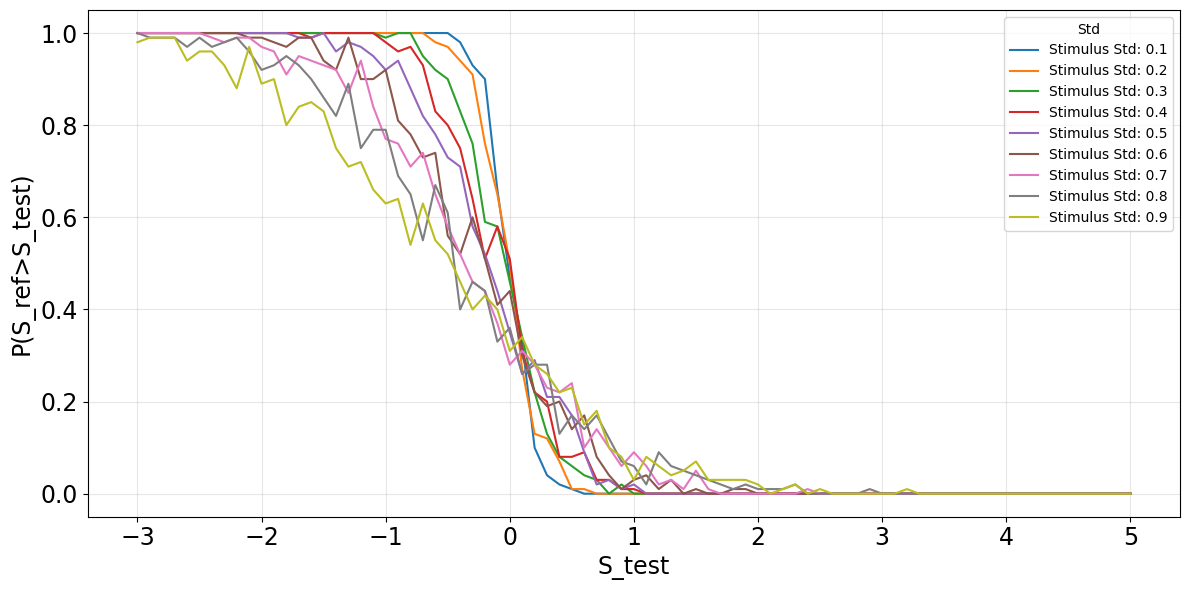

In [466]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    plt.plot(
        grouped_df['Stimulus 2 Value'],
        grouped_df['Accuracy'],
        marker= None,
        label=f"Stimulus Std: {stimulus_std}",
        linestyle='-'
    )

plt.xlabel("S_test", fontsize = 17)
plt.ylabel("P(S_ref>S_test)", fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title="Std")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [467]:
def sigmoid(x, a, b, c, d):
    """
    General sigmoid function:
    y = a / (1 + exp(-c * (x - d))) + b
    """
    return a / (1.0 + np.exp(-c * (x - d))) + b

Stimulus Std 0.1: a=-1.0015, b=1.0011, c=9.1885, d=-0.0069
Stimulus Std 0.2: a=-1.0001, b=1.0002, c=7.3740, d=-0.0191
Stimulus Std 0.3: a=-1.0029, b=1.0020, c=4.7372, d=-0.0610
Stimulus Std 0.4: a=-1.0058, b=1.0038, c=3.7057, d=-0.0998
Stimulus Std 0.5: a=-1.0060, b=1.0037, c=3.0132, d=-0.1668
Stimulus Std 0.6: a=-1.0084, b=1.0055, c=2.3937, d=-0.2436
Stimulus Std 0.7: a=-1.0103, b=1.0087, c=2.0020, d=-0.3258
Stimulus Std 0.8: a=-1.0087, b=1.0079, c=1.7484, d=-0.4120
Stimulus Std 0.9: a=-1.0259, b=1.0174, c=1.3664, d=-0.5280


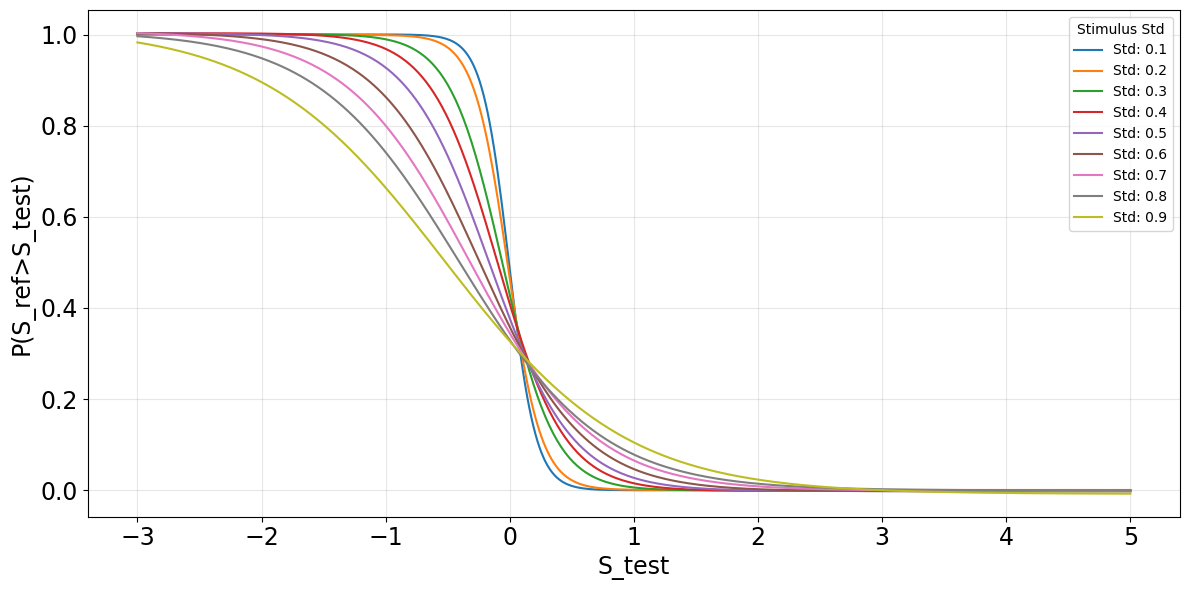

In [468]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
    print(f"Stimulus Std {stimulus_std}: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}, d={popt[3]:.4f}")
    
    x_smooth = np.linspace(min(x_data), max(x_data), 500)
    
    y_smooth = sigmoid(x_smooth, *popt)
    
    plt.plot(
        x_smooth, y_smooth,
        linestyle='-',  
        label=f"Std: {stimulus_std}"
    )

plt.xlabel("S_test", fontsize=17)
plt.ylabel("P(S_ref>S_test)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Stimulus Std", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [469]:
pse_data = []

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
    pse = popt[3]  # d is the PSE
    slope = (popt[0] * popt[2]) / 4  # (a * c) / 4
    
    pse_data.append({
        'Stimulus 2 Std': stimulus_std,
        'PSE': pse,
        'Slope at Symmetry': slope
    })
result1_df = pd.DataFrame(pse_data)
result1_df


,Stimulus 2 Std,PSE,Slope at Symmetry
0,0.1,-0.006927,-2.300625
1,0.2,-0.019054,-1.843749
2,0.3,-0.061017,-1.187781
3,0.4,-0.099786,-0.931833
4,0.5,-0.166843,-0.757822
5,0.6,-0.243563,-0.603439
6,0.7,-0.325823,-0.505621
7,0.8,-0.411997,-0.440914
8,0.9,-0.528049,-0.350467


In [470]:
# result1_df['std_post'] = np.sqrt((1 / (np.sqrt(2 * np.pi) * result1_df['Slope at Symmetry']))**2)
# result1_df

In [471]:
# result1_df['var_post'] = (1 / (np.sqrt(2 * np.pi) * result1_df['Slope at Symmetry']))**2
# result1_df

In [472]:
# result1_df['mu_lik'] = 0
# result1_df

In [473]:
experiment_name = "add_bias_mu_2"
generate_data_csv(
    min_stimulus = training_history_df_sorted['Measured Stimulus'].min().round(),
    max_stimulus = training_history_df_sorted['Measured Stimulus'].max().round(),
    step = 0.1,
    n_trial = 100,
    s_ref = 2,
    s_ref_std = 0.1,
    experiment_name=experiment_name
)

Data successfully written to add_bias_mu_2.csv


In [474]:
# add_bias_result = pd.read_csv('experiment_results.csv')

In [475]:
# add_bias_result.to_csv('add_bias_result_mu_2.csv')

In [476]:
add_bias_result_mu_2 = pd.read_csv('add_bias_result_mu_2.csv')

In [477]:
accuracy_df = (
    add_bias_result_mu_2
    # .assign(Stimulus_Diff=lambda df: df['Stimulus 1 Value'] - df['Stimulus 2 Value'])
    .groupby(['Stimulus 2 Std', 'Stimulus 2 Value'])['Comparison Result']
    .apply(lambda x: ( x.sum() / len(x)))
    .reset_index()
    .rename(columns={'Comparison Result': 'Accuracy'})
)
accuracy_df

,Stimulus 2 Std,Stimulus 2 Value,Accuracy
0,0.1,-3.0,1.00
1,0.1,-2.9,1.00
2,0.1,-2.8,1.00
3,0.1,-2.7,1.00
4,0.1,-2.6,1.00
...,...,...,...
724,0.9,4.6,0.04
725,0.9,4.7,0.02
726,0.9,4.8,0.02
727,0.9,4.9,0.01


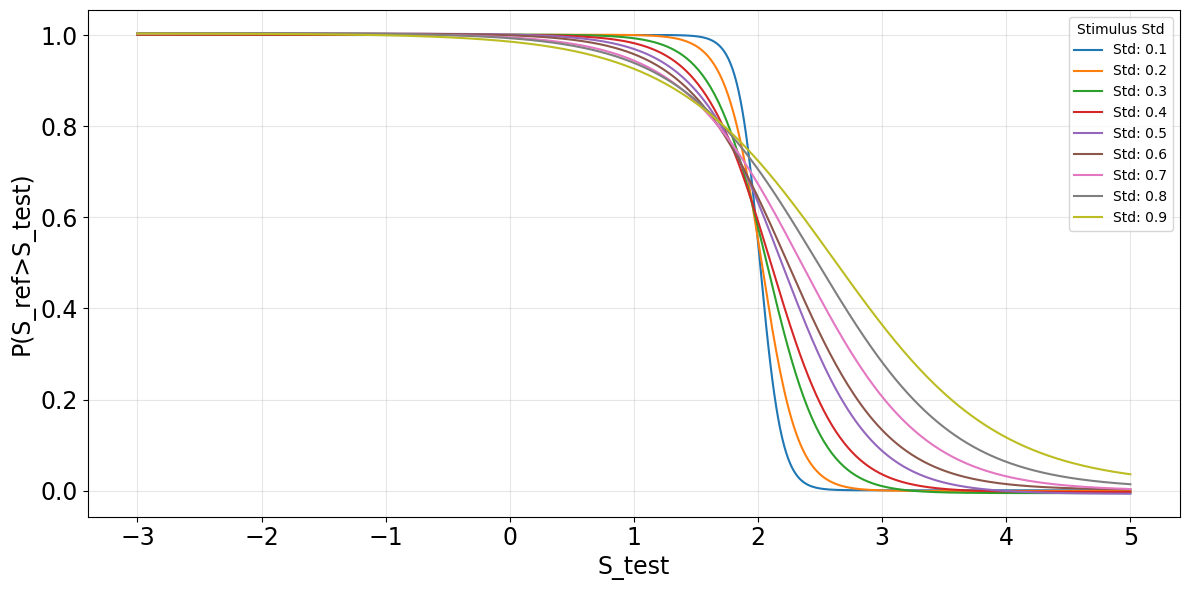

In [478]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)

    x_smooth = np.linspace(min(x_data), max(x_data), 500)
    
    y_smooth = sigmoid(x_smooth, *popt)
    
    plt.plot(
        x_smooth, y_smooth,
        linestyle='-',  
        label=f"Std: {stimulus_std}"
    )

plt.xlabel("S_test", fontsize=17)
plt.ylabel("P(S_ref>S_test)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Stimulus Std", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [479]:
result2_df = []

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
   
    pse = popt[3]  # d is the PSE
    slope = (popt[0] * popt[2]) / 4  # (a * c) / 4

    # var_lik = (0.1)**2 + stimulus_std**2
    
    result2_df.append({
        'Stimulus 2 Std': stimulus_std,
        'PSE': pse,
        'Slope at Symmetry': slope
        # 'var_lik': stimulus_std**2
    })
result2_df = pd.DataFrame(result2_df)
result2_df


,Stimulus 2 Std,PSE,Slope at Symmetry
0,0.1,2.015616,-2.847502
1,0.2,2.029343,-1.741372
2,0.3,2.072031,-1.131246
3,0.4,2.103726,-0.901265
4,0.5,2.193951,-0.712090
5,0.6,2.234433,-0.618740
6,0.7,2.346549,-0.517359
7,0.8,2.471627,-0.451978
8,0.9,2.611868,-0.380044


In [480]:
# result2_df['PSE'] = result2_df['PSE'] - 2
# result2_df

In [481]:
result2_df['std_post'] = np.sqrt((1 / (np.sqrt(2 * np.pi) * result2_df['Slope at Symmetry']))**2)
result2_df

In [482]:
result2_df['var_post'] = (1 / (np.sqrt(2 * np.pi) * result2_df['Slope at Symmetry']))**2

In [483]:
# result2_df['mu_lik'] = 2
# result2_df

In [484]:
result_df = pd.concat([result1_df, result2_df], ignore_index=True)
result_df

,Stimulus 2 Std,PSE,Slope at Symmetry
0,0.1,-0.006927,-2.300625
1,0.2,-0.019054,-1.843749
2,0.3,-0.061017,-1.187781
3,0.4,-0.099786,-0.931833
4,0.5,-0.166843,-0.757822
5,0.6,-0.243563,-0.603439
6,0.7,-0.325823,-0.505621
7,0.8,-0.411997,-0.440914
8,0.9,-0.528049,-0.350467
9,0.1,2.015616,-2.847502


In [485]:
print(result_df.columns)

Index(['Stimulus 2 Std', 'PSE', 'Slope at Symmetry'], dtype='object')


# Find Prior by Minimizing PSE bias

In [486]:
result1_df

,Stimulus 2 Std,PSE,Slope at Symmetry
0,0.1,-0.006927,-2.300625
1,0.2,-0.019054,-1.843749
2,0.3,-0.061017,-1.187781
3,0.4,-0.099786,-0.931833
4,0.5,-0.166843,-0.757822
5,0.6,-0.243563,-0.603439
6,0.7,-0.325823,-0.505621
7,0.8,-0.411997,-0.440914
8,0.9,-0.528049,-0.350467


In [502]:
from scipy.optimize import minimize

mu_0_std = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
PSE_0 = [-0.020318, -0.001386, -0.061399, -0.108976, -0.159137,
         -0.208634, -0.297272, -0.363494, -0.486370]
Slope_0 = [-2.349752, -1.743696, -1.187436, -0.928193, -0.773268,
           -0.659153, -0.497094, -0.439917, -0.366962]

mu_2_std = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
PSE_2 = [0.005192, 0.019233, 0.065601, 0.117634, 0.210569,
         0.266784, 0.441635, 0.525328, 0.616834]
Slope_2 = [-2.777980, -1.949759, -1.192057, -0.997277, -0.779532,
           -0.617296, -0.487091, -0.435119, -0.338294]

# Interpolate the PSE for any given mu
def interpolate_PSE_and_slope(mu):
    # Linear interpolation for PSE
    PSE_interpolated = (1 - mu / 2) * np.array(PSE_0) + (mu / 2) * np.array(PSE_2)
    # Linear interpolation for Slope
    Slope_interpolated = (1 - mu / 2) * np.array(Slope_0) + (mu / 2) * np.array(Slope_2)
    return PSE_interpolated, Slope_interpolated

# Cost function: minimize abs(PSE)
def cost_function(mu):
    PSE_interpolated, _ = interpolate_PSE_and_slope(mu)
    return np.min(np.abs(PSE_interpolated))  # We're looking for the minimum of abs(PSE)

# Perform the optimization
result = minimize(cost_function, x0=1, bounds=[(0, 2)])  # Start at mu=1, bounds 0 to 2

# Extract the optimal mu and corresponding values
optimal_mu = result.x[0]
PSE_interpolated, Slope_interpolated = interpolate_PSE_and_slope(optimal_mu)
min_abs_PSE_index = np.argmin(np.abs(PSE_interpolated))
optimal_PSE = PSE_interpolated[min_abs_PSE_index]
optimal_slope = Slope_interpolated[min_abs_PSE_index]

print(f"Optimal mu: {optimal_mu}")
print(f"Minimal absolute PSE: {optimal_PSE}")
print(f"Corresponding Slope at Symmetry: {optimal_slope}")
print(f"Stimulus 2 Std (Closest): {mu_0_std[min_abs_PSE_index]}")


Optimal mu: 0.9669133814702882
Minimal absolute PSE: -2.766366996587166e-10
Corresponding Slope at Symmetry: -1.189670053367887
Stimulus 2 Std (Closest): 0.3


In [488]:
# import math

# slope_at_symmetry = -1.1618533123525558
# sigma = 1 / (slope_at_symmetry * math.sqrt(2 * math.pi))
# print(f"The value of sigma is approximately: {sigma:.4f}")


In [489]:
experiment_name = "add_bias_mu_0_91"
generate_data_csv(
    min_stimulus = training_history_df_sorted['Measured Stimulus'].min().round(),
    max_stimulus = training_history_df_sorted['Measured Stimulus'].max().round(),
    step = 0.1,
    n_trial = 100,
    s_ref = 0.9172191612444508,
    s_ref_std = 0.1,
    experiment_name=experiment_name
)

Data successfully written to add_bias_mu_0_91.csv


In [490]:
# add_bias_result = pd.read_csv('experiment_results.csv')

In [491]:
# add_bias_result.to_csv('add_bias_result_mu_0_91.csv')

In [492]:
add_bias_result_mu_0_91 = pd.read_csv('add_bias_result_mu_0_91.csv')

In [493]:
accuracy_df = (
    add_bias_result_mu_0_91
    # .assign(Stimulus_Diff=lambda df: df['Stimulus 1 Value'] - df['Stimulus 2 Value'])
    .groupby(['Stimulus 2 Std', 'Stimulus 2 Value'])['Comparison Result']
    .apply(lambda x: ( x.sum() / len(x)))
    .reset_index()
    .rename(columns={'Comparison Result': 'Accuracy'})
)
accuracy_df

,Stimulus 2 Std,Stimulus 2 Value,Accuracy
0,0.1,-3.0,1.0
1,0.1,-2.9,1.0
2,0.1,-2.8,1.0
3,0.1,-2.7,1.0
4,0.1,-2.6,1.0
...,...,...,...
724,0.9,4.6,0.0
725,0.9,4.7,0.0
726,0.9,4.8,0.0
727,0.9,4.9,0.0


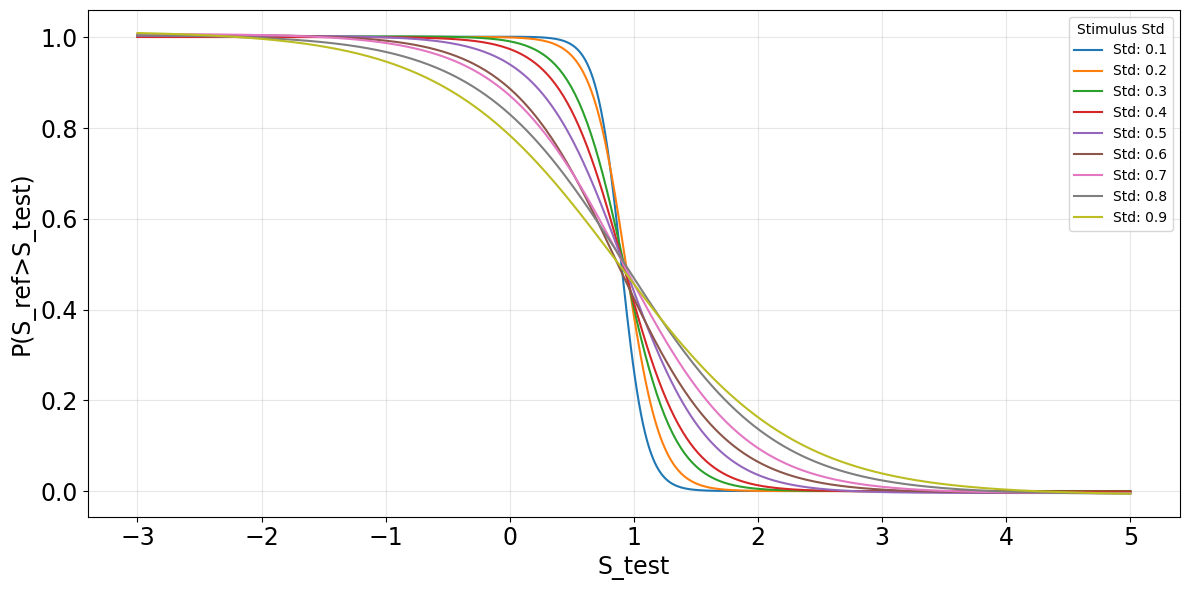

In [494]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)

    x_smooth = np.linspace(min(x_data), max(x_data), 500)
    
    y_smooth = sigmoid(x_smooth, *popt)
    
    plt.plot(
        x_smooth, y_smooth,
        linestyle='-',  
        label=f"Std: {stimulus_std}"
    )

plt.xlabel("S_test", fontsize=17)
plt.ylabel("P(S_ref>S_test)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Stimulus Std", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [495]:
result3_df = []

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
   
    pse = popt[3]  # d is the PSE
    slope = (popt[0] * popt[2]) / 4  # (a * c) / 4

    # var_lik = (0.1)**2 + stimulus_std**2
    
    result3_df.append({
        'Stimulus 2 Std': stimulus_std,
        'PSE': pse,
        'Slope at Symmetry': slope
        # 'var_lik': stimulus_std**2
    })
result3_df = pd.DataFrame(result3_df)
result3_df


,Stimulus 2 Std,PSE,Slope at Symmetry
0,0.1,0.898788,-2.512899
1,0.2,0.935345,-1.800492
2,0.3,0.918802,-1.228751
3,0.4,0.913900,-0.987945
4,0.5,0.918239,-0.742637
5,0.6,0.868787,-0.585491
6,0.7,0.913067,-0.516341
7,0.8,0.929298,-0.425673
8,0.9,0.871923,-0.363098


In [496]:
result3_df['std_post'] = np.sqrt((1 / (np.sqrt(2 * np.pi) * result3_df['Slope at Symmetry']))**2)

In [497]:
result3_df

,Stimulus 2 Std,PSE,Slope at Symmetry,std_post
0,0.1,0.898788,-2.512899,0.158758
1,0.2,0.935345,-1.800492,0.221574
2,0.3,0.918802,-1.228751,0.324673
3,0.4,0.913900,-0.987945,0.403810
4,0.5,0.918239,-0.742637,0.537197
5,0.6,0.868787,-0.585491,0.681380
6,0.7,0.913067,-0.516341,0.772633
7,0.8,0.929298,-0.425673,0.937204
8,0.9,0.871923,-0.363098,1.098717


# Find Prior
$ [Z = X_1 - X_2] $

$ [Z = S_\text{ref} - S_\text{test}] $

Posterior mean: $[ \mu_\text{post} = \frac{\mu_Z / \sigma_Z^2 + \mu_\text{prior} / \sigma_\text{prior}^2}{1 / \sigma_Z^2 + 1 / \sigma_\text{prior}^2} ]$

Posterior variance: $[ \sigma_\text{post}^2 = \left( \frac{1}{\sigma_Z^2} + \frac{1}{\sigma_\text{prior}^2} \right)^{-1} ]$

In [498]:
result1_df['var_post'] = (1 / (np.sqrt(2 * np.pi) * result1_df['Slope at Symmetry']))**2
result1_df['Stimulus 1 Std'] = 0.1
result1_df['var_z'] = result1_df['Stimulus 1 Std']**2 + result1_df['Stimulus 2 Std']**2
result1_df['mu_z'] = 0 - result1_df['PSE']
columns_to_drop = ['Stimulus 2 Std', 'Stimulus 1 Std', 'Slope at Symmetry' ]
result1_df = result1_df.drop(columns=columns_to_drop)

result1_df = result1_df.rename(columns={'PSE': 'mu_post'})
result1_df

,mu_post,var_post,var_z,mu_z
0,-0.006927,0.030070,0.02,0.006927
1,-0.019054,0.046818,0.05,0.019054
2,-0.061017,0.112810,0.10,0.061017
3,-0.099786,0.183292,0.17,0.099786
4,-0.166843,0.277131,0.26,0.166843
5,-0.243563,0.437072,0.37,0.243563
6,-0.325823,0.622543,0.50,0.325823
7,-0.411997,0.818678,0.65,0.411997
8,-0.528049,1.295765,0.82,0.528049


In [499]:
result2_df['var_post'] = (1 / (np.sqrt(2 * np.pi) * result2_df['Slope at Symmetry']))**2
result2_df['Stimulus 1 Std'] = 0.1
result2_df['var_z'] = result2_df['Stimulus 1 Std']**2 + result2_df['Stimulus 2 Std']**2
result2_df['mu_z'] = 2 - result2_df['PSE']
columns_to_drop = ['Stimulus 2 Std', 'Stimulus 1 Std', 'Slope at Symmetry' ]
result2_df = result2_df.drop(columns=columns_to_drop)

result2_df = result2_df.rename(columns={'PSE': 'mu_post'})
result2_df

,mu_post,var_post,var_z,mu_z
0,2.015616,0.019629,0.02,-0.015616
1,2.029343,0.052485,0.05,-0.029343
2,2.072031,0.124367,0.10,-0.072031
3,2.103726,0.195937,0.17,-0.103726
4,2.193951,0.313871,0.26,-0.193951
5,2.234433,0.415722,0.37,-0.234433
6,2.346549,0.594615,0.50,-0.346549
7,2.471627,0.779085,0.65,-0.471627
8,2.611868,1.101927,0.82,-0.611868


In [500]:
result_df = pd.concat([result1_df, result2_df], ignore_index=True)
result_df['mu_z'] = result_df['mu_z'] 
result_df

,mu_post,var_post,var_z,mu_z
0,-0.006927,0.030070,0.02,0.006927
1,-0.019054,0.046818,0.05,0.019054
2,-0.061017,0.112810,0.10,0.061017
3,-0.099786,0.183292,0.17,0.099786
4,-0.166843,0.277131,0.26,0.166843
5,-0.243563,0.437072,0.37,0.243563
6,-0.325823,0.622543,0.50,0.325823
7,-0.411997,0.818678,0.65,0.411997
8,-0.528049,1.295765,0.82,0.528049
9,2.015616,0.019629,0.02,-0.015616


In [501]:
def loss_function(params, df):
    mu_prior, var_prior = params
    # Predicted posterior mean and variance using the prior
    mu_post_pred = (df['mu_z'] / df['var_z'] + mu_prior / var_prior) / (1 / df['var_z'] + 1 / var_prior)
    var_post_pred = 1 / (1 / df['var_z'] + 1 / var_prior)
    
    # Calculate squared errors for both posterior mean and variance
    error_mu = ((df['mu_post'] - mu_post_pred)**2).sum()  # Error in posterior mean
    error_var = ((df['var_post'] - var_post_pred)**2).sum()  # Error in posterior variance
    
    # Total loss: sum of these squared errors
    return error_mu + error_var

# Initial guess for mu_prior and var_prior
initial_guess = [1, 1]

# Minimize the loss function using scipy.optimize
from scipy.optimize import minimize

result = minimize(loss_function, initial_guess, args=(result_df,), bounds=[(None, None), (1e-6, None)])

# Extract the optimal mu_prior and var_prior
optimal_mu_prior, optimal_var_prior = result.x

print("Optimal mu_prior:", optimal_mu_prior)
print("Optimal var_prior:", optimal_var_prior)



Optimal mu_prior: 1.012016004267179
Optimal var_prior: 1e-06
